# **Postprocesado de Probabilidades – `09_posprocesado`**


Una vez finalizada la optimización de hiperparámetros, el último bloque de experimentación se centra en explorar mejoras adicionales sobre la salida del modelo o la representación de sus entradas, sin alterar su arquitectura base. En este notebook probamos dos estrategias complementarias:

---

###  **Parte I – Postprocesado de Probabilidades (LightGBM)**
El modelo LightGBM fue el que ofreció **el mejor AUC-ROC medio** con su configuración base. En esta fase se analiza si aplicar un **ajuste en los valores extremos de probabilidad predicha** puede mejorar su rendimiento en validación.

#### 🎯 Objetivo

Evaluar si el redondeo de probabilidades extremas predichas por el modelo mejora o estabiliza el AUC-ROC en la detección de eventos grasp-and-lift.

#### 🧪 Estrategia aplicada:

- Si `p < 0.01` → forzar a `0`
- Si `p > 0.99` → forzar a `1`
- En caso contrario → mantener el valor original

Esta transformación se aplica **después de `predict_proba()`** y busca reforzar la certeza del modelo sin perder capacidad de discriminación. A diferencia del umbral 0.5 (que reduce el AUC), este enfoque preserva la ordenación y el rango de probabilidades intermedias.

#### 🧬 Justificación:

- No altera el entrenamiento ni los hiperparámetros del modelo.
- Mejora la interpretabilidad en entornos de despliegue.
- No perjudica el cálculo del AUC, que se basa en ranking y no en clasificación binaria directa.

#### 🚀 **Flujo de Trabajo en esta parte**

1️⃣ **Predicción con el modelo LightGBM base**

Se entrena el modelo sobre los datos originales y se obtienen las probabilidades para cada evento.

2️⃣ **Aplicación del postprocesado**

Se redondean las probabilidades extremas según el criterio definido (`< 0.01 → 0`, `> 0.99 → 1`).

3️⃣ **Evaluación y comparación de AUC**

Se comparan los AUC-ROC por evento antes y después del postprocesado para analizar su impacto.

4️⃣ **Discusión de resultados**

Se interpretan los cambios observados (si los hay) y se discute la utilidad del postprocesado como paso adicional en la cadena de modelado.

---

### **Parte II – Mejora Estructural: Reducción de Dimensionalidad con Autoencoders**

En esta sección se estudia si un modelo **autoencoder** puede condensar las **512 características actuales** en un espacio **latente más compacto** (≈100), manteniendo la mayor cantidad de información útil.

#### 🎯 Objetivo

Explorar si la reducción de dimensionalidad no supervisada permite:

- Mejorar la generalización del modelo LightGBM.
- Minimizar redundancia entre variables temporales/frecuenciales.
- Mantener (o mejorar) el rendimiento sin perder señales discriminativas.

---

#### 🚀 **Flujo de Trabajo en esta parte**

1️⃣ **Definir y entrenar un Autoencoder** con `Keras` o `sklearn`:
   - Capa de entrada: 512 nodos (número de features actuales).
   - Capas ocultas: compresión progresiva hasta 100 nodos (cuello de botella).
   - Simétrica: decodificación desde el espacio latente.
   - Optimización por MSE, activación `relu`, `adam`, y `early_stopping`.

2️⃣ **Extraer las representaciones comprimidas** (output del encoder) para cada muestra.

3️⃣ **Entrenar un modelo LightGBM nuevo** usando solo esas representaciones comprimidas.

4️⃣ **Comparar el rendimiento AUC** evento por evento:
   - LightGBM con features originales
   - LightGBM con features comprimidas por autoencoder

5️⃣ **Interpretar resultados**:
   - ¿Pierde capacidad predictiva?
   - ¿Mejora la estabilidad?
   - ¿Reduce el sobreajuste?

---

## **1. POSTPROCESADO**

## **1.1 Carga de datos preprocesados**

In [2]:
import os
import pickle
import pandas as pd

# Ruta de los datos procesados
processed_path = r"C:\Users\luciaft\Documents\TFG\TFG\graspAndLiftDetectionTFGProyect\data\processed"
data_file = os.path.join(processed_path, "preprocessed_features_temporal_freq.pkl")

# Cargar los datos preprocesados
with open(data_file, "rb") as f:
    X_train_scaled, y_train_win, X_valid_scaled, y_valid_win = pickle.load(f)

#Cargamos también los resultados obtenidos con el modelo base
auc_file = os.path.join(processed_path, "auc_results_feats_logreg.csv")

# Cargar CSV y convertir a diccionario
auc_df = pd.read_csv(auc_file, index_col="Evento")
auc_dict_logreg = auc_df["AUC"].to_dict()


# Verificar formas
print("Datos cargados correctamente:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_win shape: {y_train_win.shape}")
print(f"X_valid_scaled shape: {X_valid_scaled.shape}")
print(f"y_valid_win shape: {y_valid_win.shape}")

# Verificar diccionario con resultados
print(auc_dict_logreg)

Datos cargados correctamente:
X_train_scaled shape: (1043205, 512)
y_train_win shape: (1043205, 6)
X_valid_scaled shape: (236894, 512)
y_valid_win shape: (236894, 6)
{'HandStart': 0.8928, 'FirstDigitTouch': 0.8838, 'BothStartLoadPhase': 0.8888, 'LiftOff': 0.9059, 'Replace': 0.8966, 'BothReleased': 0.8751}


## **1.2 Modificación de la Función de Evaluación**

In [7]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np

#Defición de función de evaluación por evento 
def evaluate_model(model, X_train, y_train, X_valid, y_valid, model_name="Model"):
    results = {}
    for i, event in enumerate(y_train.columns):
        model.fit(X_train, y_train[event])
        y_pred_proba = model.predict_proba(X_valid)[:, 1]

        # Postprocesado: redondear probabilidades extremas
        y_pred_proba = np.where(y_pred_proba < 0.01, 0, y_pred_proba)
        y_pred_proba = np.where(y_pred_proba > 0.99, 1, y_pred_proba)

        auc = roc_auc_score(y_valid[event], y_pred_proba)
        results[event] = auc
        print(f"{model_name} - {event}: AUC = {auc:.4f}")
    return results


import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")

lgbm = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_results = evaluate_model(lgbm, X_train_scaled, y_train_win, X_valid_scaled, y_valid_win, model_name="LightGBM")

[LightGBM] [Info] Number of positive: 24807, number of negative: 1018398
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.212123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130346
[LightGBM] [Info] Number of data points in the train set: 1043205, number of used features: 512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.023780 -> initscore=-3.714860
[LightGBM] [Info] Start training from score -3.714860
LightGBM - HandStart: AUC = 0.7779
[LightGBM] [Info] Number of positive: 24918, number of negative: 1018287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.157088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130346
[LightGBM] [Info] Number of data points in the train set: 1043205, number of used features: 512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.023886 -> initscore=-3.710287
[LightGBM] [Info]

| Evento                | AUC sin Postprocesado | AUC con Postprocesado |
|-----------------------|------------------------|------------------------|
| HandStart             | 0.8693                 | 0.7779                 |
| FirstDigitTouch       | 0.8975                 | 0.7255                 |
| BothStartLoadPhase    | 0.9098                 | 0.8016                 |
| LiftOff               | 0.9058                 | 0.7892                 |
| Replace               | 0.8902                 | 0.8290                 |
| BothReleased          | 0.8801                 | 0.8047                 |

#### Interpretación

El postprocesado aplicado en esta fase, aunque conceptualmente razonable para reforzar predicciones en los extremos, **provoca una caída significativa del AUC-ROC en todos los eventos**. Esto confirma que, en tareas donde el rendimiento se mide con AUC:

- **Cualquier alteración de las probabilidades predichas** (incluso pequeñas, como forzar extremos) **puede perjudicar la calidad de ordenación** entre positivos y negativos.
- La métrica AUC **no se beneficia de decisiones discretas**, ya que **valora la continuidad y orden relativo** de las probabilidades.

 Por tanto, aunque el redondeo de extremos podría tener valor práctico en un sistema desplegado (ej. cuando se toman decisiones binarias), **no es recomendable aplicarlo cuando el objetivo principal es optimizar el AUC-ROC**.

## **2. AUTOENCODERS**

## **2.1 Reducción de Dimensionalidad con Autoencoder (512 → 100)**

El objetivo del autoencoder es **reducir el espacio de características** de 512 dimensiones originales (temporales + frecuenciales) a una **representación latente de 100 dimensiones** que conserve la información esencial para la detección de eventos motores.

### Arquitectura del Autoencoder

| Componente        | Valor elegido | Justificación técnica |
|-------------------|---------------|------------------------|
| `input_dim`       | 512           | Corresponde al número total de características combinadas tras el preprocesado de datos EEG. |
| `encoding_dim`    | 100           | Se elige como compromiso entre compresión (reducción del 80%) y retención de información. Al reducir a solo 50 características se observó pérdida significativa de rendimiento. |
| `encoded layers`  | [256, 128]    | Capas de reducción progresiva (factor ≈ 2), típicas en autoencoders simétricos. Ayudan a filtrar ruido y a aprender una representación útil sin saltos bruscos de dimensión. |
| `bottleneck`      | 100 (`relu`)  | Capa clave donde se obtiene la representación comprimida. Se mantiene una activación `relu` para garantizar no linealidad sin saturación negativa. |
| `decoded layers`  | [128, 256]    | Simétricas respecto al encoder. Permiten reconstruir la entrada a partir de la codificación latente. |
| `output activation` | `linear`    | No se usa `sigmoid` o `relu` en la salida para evitar forzar un rango artificial. La salida debe imitar los valores reales originales del input normalizado. |

---

###  Parámetros de Entrenamiento

| Parámetro           | Valor elegido | Justificación |
|---------------------|---------------|---------------|
| `optimizer`         | `"adam"`      | Optimizador robusto para redes pequeñas/medianas, con buen desempeño en tareas de reconstrucción sin ajustes finos. |
| `loss`              | `"mse"`       | Métrica estándar para tareas de reconstrucción continua. Evalúa la diferencia entre la entrada y la salida reconstruida. |
| `batch_size`        | 256           | Tamaño razonable que acelera el entrenamiento y estabiliza el gradiente, ajustado para datos grandes como los EEG (más de 1 millón de muestras). |
| `epochs`            | 100           | Límite superior. Se corta antes si no mejora por `early stopping`. |
| `validation_split`  | 0.1           | Se reserva un 10% para validar y evitar sobreajuste. |
| `EarlyStopping`     | `patience=5`  | Detiene el entrenamiento si no mejora el `val_loss` en 5 épocas consecutivas. |




La arquitectura y parámetros seleccionados representan un balance entre compresión, estabilidad y preservación de información relevante. El autoencoder no se entrena con etiquetas, por lo que se espera que la representación latente aprendida refuerce patrones estructurales de los datos sin forzar una optimización específica sobre eventos concretos.

Epoch 1/100
3668/3668 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.3460 - val_loss: 0.2179
Epoch 2/100
3668/3668 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.2399 - val_loss: 0.2181
Epoch 3/100
3668/3668 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.2441 - val_loss: 0.2110
Epoch 4/100
3668/3668 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 0.2386 - val_loss: 0.3757
Epoch 5/100
3668/3668 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.2462 - val_loss: 0.2077
Epoch 6/100
3668/3668 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.2201 - val_loss: 0.2343
Epoch 7/100
3668/3668 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 0.2503 - val_loss: 0.2314
Epoch 8/100
3668/3668 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.2383 - val_loss: 0.2583
Epoch 9/100
3668/3668 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.2666 - val_loss: 0.2331
Epoch 10/100
3668/3668 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.2394 - val_loss: 0.2359


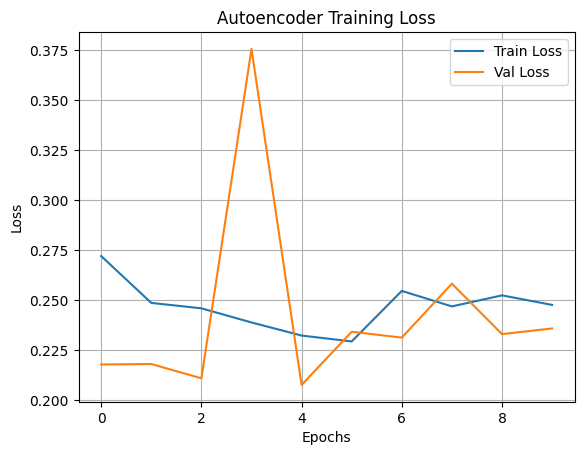

32601/32601 ━━━━━━━━━━━━━━━━━━━━ 33s 997us/step
7403/7403 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Forma original: (1043205, 512)
Forma reducida: (1043205, 100)


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Suponemos que ya tienes esto cargado:
# X_train_scaled (n_samples, 512)
# Puedes usar también np.array(X_train_scaled) si era un DataFrame

input_dim = X_train_scaled.shape[1]  # 512
encoding_dim = 100                   # Queremos reducir a 100 características

# === Definir arquitectura del Autoencoder ===
input_layer = Input(shape=(input_dim,))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
bottleneck = Dense(encoding_dim, activation='relu', name="bottleneck")(encoded)

decoded = Dense(128, activation='relu')(bottleneck)
decoded = Dense(256, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)

# === Compilar ===
autoencoder.compile(optimizer='adam', loss='mse')

# === Entrenar ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_train_scaled,
    X_train_scaled,
    epochs=100,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# === Visualizar pérdida ===
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.title("Autoencoder Training Loss")
plt.show()

# === Crear modelo con solo el encoder ===
encoder = Model(inputs=input_layer, outputs=autoencoder.get_layer("bottleneck").output)

# === Reducir los datos ===
X_train_encoded = encoder.predict(X_train_scaled)
X_valid_encoded = encoder.predict(X_valid_scaled)

print(f"Forma original: {X_train_scaled.shape}")
print(f"Forma reducida: {X_train_encoded.shape}")

## **2.2 Evaluación con LightGBM sobre Representaciones Latentes (Autoencoder)**

Entrenamos y evaluamos un modelo **LightGBM** utilizando los datos comprimidos a 100 dimensiones mediante un **Autoencoder** previamente entrenado. La función `evaluate_model` permite analizar el rendimiento AUC-ROC por evento motor individual.

Este enfoque evalúa si una representación **más compacta pero densa en información** puede mantener (o incluso mejorar) el rendimiento de los modelos clásicos, reduciendo a la vez la dimensionalidad de entrada.

In [6]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, classification_report

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")


#Defición de función de evaluación por evento 
def evaluate_model(model, X_train, y_train, X_valid, y_valid, model_name="Model"):
    results = {}
    for i, event in enumerate(y_train.columns):
        model.fit(X_train, y_train[event])
        y_pred_proba = model.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid[event], y_pred_proba)
        results[event] = auc
        print(f"{model_name} - {event}: AUC = {auc:.4f}")
    return results

# Entrenar y evaluar LightGBM con datos reducidos a 100 dimensiones
lgbm = LGBMClassifier(n_estimators=100, random_state=42)

lgbm_results_encoded = evaluate_model(
    lgbm,
    X_train_encoded, y_train_win,
    X_valid_encoded, y_valid_win,
    model_name="LightGBM (Autoencoder)"
)

[LightGBM] [Info] Number of positive: 24807, number of negative: 1018398
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 1043205, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.023780 -> initscore=-3.714860
[LightGBM] [Info] Start training from score -3.714860
LightGBM (Autoencoder) - HandStart: AUC = 0.8230
[LightGBM] [Info] Number of positive: 24918, number of negative: 1018287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 1043205, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.023886 -> initscore=-3.710287
[LightG

### Evaluación Comparativa – Reducción de Dimensionalidad con Autoencoder vs Modelo Base y SFS

Con el objetivo de reducir la dimensionalidad de entrada y evaluar si es posible mantener o mejorar el rendimiento, se han probado dos enfoques principales sobre el modelo **LightGBM**:

1. **Autoencoder** (compresión no supervisada a 100 dimensiones)
2. **SFS** (selección de características mediante `SequentialFeatureSelector`)

Se comparan ambos enfoques con el modelo **base con 512 características**.

---

### Resultados AUC-ROC por Evento (LightGBM)

| Evento               | Base (512 features) | Autoencoder (100) | SFS (features seleccionadas) |
|----------------------|---------------------|--------------------|------------------------------|
| HandStart            | **0.8693**          | 0.8230             | 0.8403                       |
| FirstDigitTouch      | **0.8975**          | 0.8323             | 0.8633                       |
| BothStartLoadPhase   | **0.9098**          | 0.8397             | 0.8827                       |
| LiftOff              | **0.9058**          | 0.8269             | 0.8945                       |
| Replace              | **0.8902**          | 0.8631             | 0.8795                       |
| BothReleased         | **0.8801**          | 0.8385             | 0.8784                       |

---

### Análisis

-  **LightGBM con 512 características** es claramente el modelo con mejor rendimiento general, liderando en todos los eventos.
-  **Autoencoder** ofreció un rendimiento razonable pese a reducir un 80% las dimensiones, pero **en todos los eventos el AUC disminuyó** notablemente.
-  **SFS** logró resultados mejores que el autoencoder, pero **aún inferiores al modelo completo**. La pérdida es menor, pero presente.
-  El evento **`BothStartLoadPhase`** es donde más se nota la pérdida con autoencoder (de 0.9098 a 0.8397).

---

###  Conclusión Técnica

La **reducción de dimensionalidad**, tanto con **autoencoders** como con **SFS**, **no ha conseguido mantener el rendimiento** del modelo original. Aunque podrían ser útiles para acelerar entrenamiento o evitar sobreajuste en otros contextos, en este caso:

- Las 512 características originales parecen contener **información valiosa que se pierde** al reducir.
- El tiempo extra de entrenamiento con 512 características (≈1.6s frente a ≈0.15s por fold) es **aceptable dado el beneficio en rendimiento**.
